In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import pathlib
import torch.optim as optim

from torch.utils.data import DataLoader

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [31]:
def get_rotten_data(augmentation=0):
    # Transformation to reduce overfitting
    if augmentation:
        # Transform the data for consistency
        transform_train = transforms.Compose([
        transforms.Resize(500),
        transforms.RandomCrop(200, padding=4, padding_mode='edge'), # Take 32x32 crops from 40x40 padded images
        transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis 2 -> 5
        transforms.ToTensor(),
    ])
        transform_test = transform_train
    else:
        # Keep and use original dimensions of image
        transform_train = transforms.ToTensor()
    
        transform_test = transforms.Compose([
            transforms.Resize(128),
            transforms.ToTensor(),
    ])

    # Data Loader

    # Training & Testing Paths
    train_path = './dataset/train/'
    test_path = './dataset/test/'

    # Converts images in folders into usable dictionaries
    train_loader = DataLoader(
        torchvision.datasets.ImageFolder(train_path, transform=transform_train), batch_size=128, shuffle=True, num_workers=2
    )
    test_loader = DataLoader(
        torchvision.datasets.ImageFolder(test_path, transform=transform_test), batch_size=128, shuffle=True, num_workers=2
    )

    # Fruit Categories
    root=pathlib.Path(train_path)
    classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
    return {'train': train_loader, 'test': test_loader, 'classes': classes}

data = get_rotten_data(augmentation=1)


torch.Size([128, 3, 32, 32])


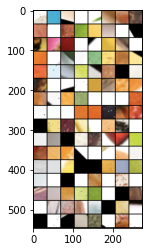

Labels:rottenoranges freshbanana rottenapples freshapples freshbanana freshbanana rottenoranges rottenbanana
torch.Size([128, 3, 32, 32])
torch.Size([128, 3072])


In [32]:
dataiter = iter(data['train'])
images, labels = dataiter.next()
print(images.size())

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print("Labels:" + ' '.join('%9s' % data['classes'][labels[j]] for j in range(8)))


flat = torch.flatten(images, 1)
print(images.size())
print(flat.size())


In [33]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__() # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        # Input 32x32x3 image
        # 16 filters
        # 3x3 filter size (they also have 3 channels)
        # stride 2 (downsampling by factor of 2)
        # Output image: 16x16x16
        self.conv1 = nn.Conv2d(3, , 3, stride=2, padding=1)

        # Input 16x16x16 image
        # 32 filters
        # 3x3x16 filter size (they also have 16 channels)
        # stride 2 (downsampling by factor of 2)
        # Output image: 8x8x32
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)


        # Exercise left to the reader
        # Output image: 4x4x64 -> 1024 neurons
        self.conv3 = nn.Conv2d(32, 64, 3, stride=2, padding=1)

        self.fc1 = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x) # Unnormalized Probabilities
        return x

In [34]:
def train(net, dataloader, epochs=1, lr=0.01, momentum=0.9, decay=0.0, verbose=1):
  net.to(device)
  losses = []
  criterion = nn.CrossEntropyLoss() # Combination softmax + negative log likelihood
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)
  for epoch in range(epochs):
    sum_loss = 0.0
    for i, batch in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch[0].to(device), batch[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  # autograd magic, computes all the partial derivatives
        optimizer.step() # takes a step in gradient direction

        # print statistics
        losses.append(loss.item())
        sum_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            if verbose:
              print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, sum_loss / 100))
            sum_loss = 0.0
  return losses

def accuracy(net, dataloader):
  correct = 0
  total = 0
  with torch.no_grad():
      for batch in dataloader:
          images, labels = batch[0].to(device), batch[1].to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return correct/total

def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='valid')

Training accuracy: 0.462435
Testing  accuracy: 0.469607


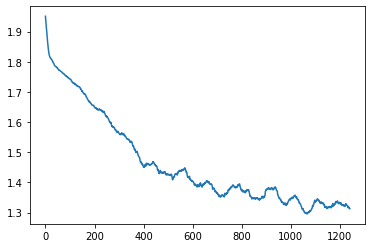

In [35]:
conv_net = ConvNet()

conv_losses = train(conv_net, data['train'], epochs=15, lr=.01)
plt.plot(smooth(conv_losses, 50))

print("Training accuracy: %f" % accuracy(conv_net, data['train']))
print("Testing  accuracy: %f" % accuracy(conv_net, data['test']))